# Model Training Notebook

In [2]:
# Requirements
# (update pip)
# fastai
# scikit-image

Package versions and available devices:

In [1]:
import fastai
import torch



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"fastai version : {fastai.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Number of GPUs : {torch.cuda.device_count()}")
print(f"Device         : {device}")

fastai version : 2.7.12
PyTorch version: 2.0.1
Number of GPUs : 0
Device         : cpu


In [ ]:
from fastai.vision.all import *
from fastai.data.all import *

from pathlib import Path

In [ ]:
import skimage.io

In [ ]:
# RNG for frame selection
nprng = np.random.default_rng(123)

def imread2pil_train(fpath):
    '''
    read the middle frame and convert to PIL image.
    
    Image files should contain 3 channels.
    '''
    # use print to test datasets:
    # print(fpath)
    
    im = skimage.io.imread(str(fpath))
    
    # assuming images have 3 channels:
    if im.ndim<4:
        im = im[np.newaxis,...]
    
    # later need to add separate normalization for each channel,
    # now using only 2nd ch:CH1 of CH:0-2
    im = np.uint8( 255 * (im/im[:,:,:,1].max()) )
    
    if fpath.parents[1].name=="train":
        # select random frame is it's training data:
        frame_id = nprng.integers(im.shape[0])
    else:
        # for val data use middle frame
        frame_id = im.shape[0]//2
    return PILImage.create(im[frame_id][:,:,1])

---
A similar image loading func-n for the prediction stage:

In [ ]:
def imread2pil(fpath):
    '''
    read the middle frame and convert to PIL image.
    
    Image files should contain 3 channels.
    '''
    # use print to test datasets:
    # print(fpath)
    
    im = skimage.io.imread(str(fpath))
    
    # assuming images have 3 channels:
    if im.ndim<4:
        im = im[np.newaxis,...]
    
    # later need to add separate normalization for each channel,
    # now using only 2nd ch:CH1 of CH:0-2
    im = np.uint8( 255 * (im/im[:,:,:,1].max()) )
    
    frame_id = im.shape[0]//2
    return PILImage.create(im[frame_id][:,:,1])

***Location of training dataset (main folder that contains "yes"/"no" folders)***:
> If the dataset is randomly split, e.g. 80% training and 20% validation, use seed for reproducibility, you need consistent train and val datasets to compare different models and training conditions.

- The original dataset contained images with either single channel. I manually removed these images into a separate folder.

- *Below, I assume all images have 3 channels*.

In [9]:
#
# data_path = Path('/mnt/mbi/images/micros/murat/dataDIR/maria_21072023/')
data_path = Path('../../dataDIR/maria_21072023/')
get_image_files(data_path)[400]

Path('../../dataDIR/maria_21072023/train/yes/liveJun8-02.czi - liveJun8-02.czi #002-3_y.tif')

In [10]:
cell_dataset = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                         get_items=get_image_files,
                         splitter=GrandparentSplitter(),
                         get_x=imread2pil_train,
                         get_y=parent_label,
                         item_tfms = Resize(224)
                        )

# debugging: use `cell_dataset.summary(data_path)`

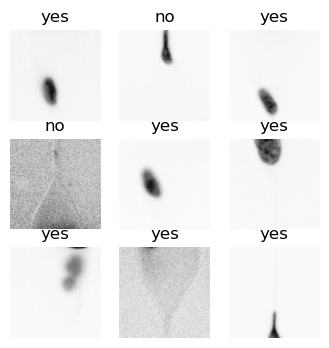

In [11]:
dls = cell_dataset.dataloaders(data_path)
dls.show_batch(max_n=9, figsize=(4,4))

In [26]:
print('Dataset sizes: \"train, val\"-->',[len(k) for k in dls.splits])

Dataset sizes: "train, val"--> [346, 88]


In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [15]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.150243,1.887542,1.000000,00:19


epoch,train_loss,valid_loss,error_rate,time
0,1.229117,1.115295,1.000000,00:33


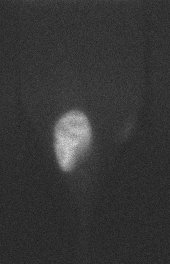

In [112]:
pil_img_k = imread2pil(img_fns[230]); pil_img_k

In [110]:
img_fns[230]

Path('../../dataDIR/maria_21072023/yes/liveJun8-02.czi - liveJun8-02.czi #058-2_y.tif')

In [113]:
# Need to use --> Resize(224)(input_img) to match training data
learn.predict(Resize(224)(pil_img_k))

('no', tensor(0), tensor([0.9435, 0.0565]))

In [16]:
learn.save('./test')

Path('models/test.pth')

In [58]:
# Downloaded model weight are stored at:
# torch.hub.get_dir()
# e.g.
# ~/.cache/torch/hub/checkpoints # for Mac OS

In [44]:
# re-initialise the model with a downloaded model (trained on IMAGENET dataset)
# pre-trained models (torchhub): from torchvision.models import resnet34
# 
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [21]:
# load previously saved weights
learn.load('./test')

In [62]:
# continue training
#
# learn.fine_tune(...)